In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand
import pandas as pd

from simulation_functions import run_simulation

In [2]:
elements = 10000

rand_FWHM = (rand(elements) * 3) + 3
rand_radius = (rand(elements) * 6) + 7
rand_A = (rand(elements) * 40)

data = run_simulation(rand_FWHM, rand_radius, rand_A, mp_processes = 8)

Simulating 10000 points
Launching 8 threads 



100%|██████████| 10000/10000 [03:11<00:00, 52.18it/s]



All threads completed! Total time: 0 h, 3 min, 18 s


In [3]:
data.head()

,FWHM,volume,volume2area,A_est,A_true,analytical,b_x,b_nx,b_y,b_ny,b_z,b_nz
0,4.017530,963,2.173815,21.374872,31.123312,21.378472,0.097129,0.041559,0.052603,0.086085,0.072694,0.065994
1,4.986198,1289,2.281416,22.233877,33.998322,21.409798,0.115797,0.063631,0.077809,0.101619,0.094788,0.084640
2,4.733324,1346,2.262185,6.385089,9.484405,6.122383,0.032968,0.018399,0.021763,0.029603,0.028061,0.023305
3,5.088461,898,2.054920,20.755202,34.000468,19.736879,0.099657,0.072491,0.086192,0.085956,0.091562,0.080585
4,5.113855,2464,2.784181,6.880126,9.686151,6.672072,0.048548,0.020477,0.026308,0.042716,0.036417,0.032607


In [4]:
data.describe()

,FWHM,volume,volume2area,A_est,A_true,analytical,b_x,b_nx,b_y,b_ny,b_z,b_nz
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.491300,2189.347700,2.638483,14.353998,19.939806,14.047810,0.078858,0.040748,0.048287,0.071318,0.063926,0.055680
std,0.863940,1014.672636,0.405427,8.476796,11.593333,8.343093,0.050271,0.028357,0.031989,0.045538,0.040731,0.035942
min,3.000152,731.000000,1.828916,0.009133,0.011811,0.008973,0.000034,0.000020,0.000023,0.000030,0.000029,0.000025
25%,3.737056,1284.750000,2.284467,7.068437,9.877074,6.900270,0.037092,0.018124,0.022422,0.033572,0.030358,0.026058
50%,4.496082,1973.000000,2.630147,14.176386,19.866577,13.854672,0.074764,0.036571,0.044788,0.067673,0.060690,0.052445
75%,5.224970,2982.250000,2.990837,21.421799,29.969411,20.930620,0.114297,0.058308,0.069449,0.103112,0.092488,0.080464
max,5.999494,4376.000000,3.534751,33.342397,39.998817,33.305148,0.264511,0.162739,0.179017,0.225852,0.201411,0.177773


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

df_train = data.dropna().sample(frac=0.8, random_state=0)
df_test = data.dropna().drop(df_train.index)

train_labels = df_train.pop("A_true")
test_labels = df_test.pop("A_true")

normalizer = tf.keras.layers.Normalization(axis=-1)

normalizer.adapt(np.array(df_train))
print(normalizer.mean.numpy())

def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(32, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.005))
    return model


dnn_model = build_and_compile_model(normalizer)

2025-01-08 14:40:28.267104: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-08 14:40:30.679194: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


[[4.5009627e+00 2.1809976e+03 2.6348317e+00 1.4420241e+01 1.4110848e+01
  7.9304412e-02 4.0980455e-02 4.8574489e-02 7.1710341e-02 6.4289443e-02
  5.5995386e-02]]


In [6]:
history = dnn_model.fit(
    df_train,
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=50)

Epoch 1/50
200/200 [==============================] - 2s 5ms/step - loss: 3.9806 - val_loss: 0.6556
Epoch 2/50
200/200 [==============================] - 1s 3ms/step - loss: 0.5211 - val_loss: 0.4197
Epoch 3/50
200/200 [==============================] - 1s 3ms/step - loss: 0.3353 - val_loss: 0.2419
Epoch 4/50
200/200 [==============================] - 1s 4ms/step - loss: 0.2662 - val_loss: 0.1919
Epoch 5/50
200/200 [==============================] - 1s 5ms/step - loss: 0.2489 - val_loss: 0.2082
Epoch 6/50
200/200 [==============================] - 1s 4ms/step - loss: 0.2374 - val_loss: 0.1544
Epoch 7/50
200/200 [==============================] - 1s 4ms/step - loss: 0.2493 - val_loss: 0.2420
Epoch 8/50
200/200 [==============================] - 1s 4ms/step - loss: 0.2245 - val_loss: 0.1985
Epoch 9/50
200/200 [==============================] - 1s 4ms/step - loss: 0.2227 - val_loss: 0.2014
Epoch 10/50
200/200 [==============================] - 1s 4ms/step - loss: 0.2146 - val_loss: 0.1531

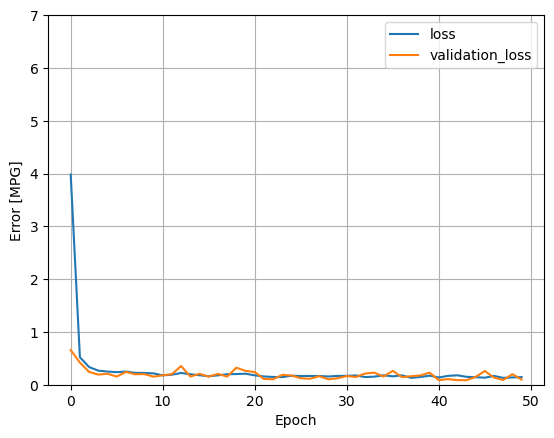

In [7]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='validation_loss')
    plt.ylim([0, 7])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    # plt.yscale()
    plt.legend()
    plt.grid(True)
    
plot_loss(history)

63/63 [==============================] - 0s 2ms/step - loss: 0.0979
0.0979481115937233


Text(0, 0.5, 'True activity')

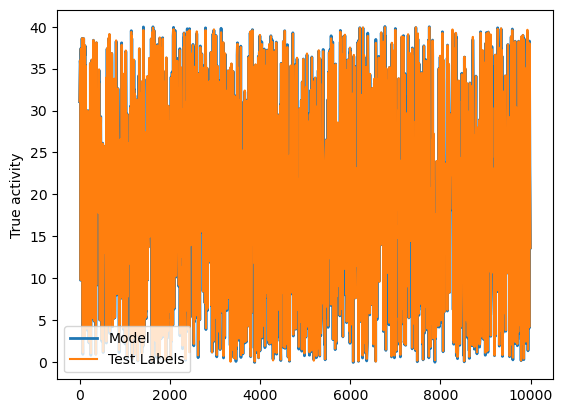

In [8]:
dnn_model.evaluate(df_test, test_labels, verbose=1)

x = tf.linspace(1, 20, 420)
y = dnn_model.predict(df_test)
test_result = dnn_model.evaluate(df_test, test_labels)
print(test_result)

plt.plot(list(test_labels.index), y, label = "Model", linewidth = 2)
plt.plot(list(test_labels.index), test_labels, label = "Test Labels")
plt.legend()
plt.ylabel("True activity")